# Week 06 Lab: Liquid Argon Simulation


## Student Name: YOUR NAME HERE

![Liquid Argon](https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Argon_ice_1_edit.jpg/1344px-Argon_ice_1_edit.jpg?20070502070646)

Today we'll combine our knowledge of Classical Mechanics with the concepts of **periodic boundary conditions**, **Maxwell-Boltzmann distributions** and **Lennard-Jones interactions** that we learned in the last lecture.

We will apply these to the simulation of **Liquid Argon**.  Argon, or course, is a noble gas at room temperature.  But below its boiling point (87 K), it forms a liquid that is held together by van der Waals interactions. 

Since each Argon atom is uncharged and forms no covalent bonds, this is actually one of the simplest many-particle systems we can study!

**Let's start by recalling some of the functions we've already written that can help us:**

In [2]:
from scipy.special import erfinv
import numpy as np

def init_vel(kt_over_m, shape):
    """
    Initializes velocities according to the Maxwell-Boltzmann distribution.
    
    Inputs:
    kt_over_m : float
                The value of kT/m 
    
    shape :     tuple (of int)
                The shape of the velocity array to return
    """
    
    R = np.random.random(shape)   # generates a set of numbers uniformly in [0,1]
    return np.sqrt(2*kt_over_m)*erfinv(2*R-1)
    
def apply_pbc(positions, box_size):
    """
    Wraps the positions to conform to the periodic boundaries.  
    
    Inputs:
    positions : array, shape (N,ndim)
                Positions of the particles
                
    box_size :  array, shape (ndim)
                Length of the periodic unit cell in each dimension
    """
    # positions and box size are both arrays with
    # a dimensionality equal to the number of spatial dimensions
    # i.e. if we are in 2D space, each array has two elements
    
    half_box_size = box_size * 0.5
    pbc_wrap_positions = np.zeros_like(positions)

    old_positions = positions

    # this while loop allows adjustments to be made until 
    # the positions of the particles stops changing
    while np.any(pbc_wrap_positions != old_positions):
        #
        # Note on np.where syntax:
        # np.where(CONDITION, value_if_true, value_if_false)
        #
        pbc_wrap_positions = np.where(positions > half_box_size,
                                      positions - box_size,
                                      positions)

        pbc_wrap_positions = np.where(positions <= -half_box_size,
                                      positions + box_size,
                                      pbc_wrap_positions)
        old_positions = pbc_wrap_positions
    return pbc_wrap_positions

def shortest_disp_vector(posA, posB, box_size):
    """
    Returns the shortest displacement vector between two atoms.
    
    Inputs:
    posA     :  array, shape (ndim)
                position of particle A
    
    posB     :  array, shape (ndim)
                position of particle B
    
    box_size :  array, shape (ndim)
                Length of the periodic unit cell in each dimension
    """

    r = posA - posB   # has one element for each spatial dimension

    # loop over spatial dimensions
    for i in range(len(posA)):
        
        # if difference is greater than half the box length, adjust
        if r[i] < -0.5*box_size[i]:
            
            # determine number of adjustments needed
            n = int((r[i] + 0.5*box_size[i])/box_size[i]) + 1  

            # make them
            r[i] += n*box_size[i]
        elif r[i] > 0.5*box_size[i]: # same thing in the negative direction
            n = int((r[i] - 0.5*box_size[i])/box_size[i]) + 1
            r[i] -= n*box_size[i]

    return r

def VVLangevin(x, v, m, force_alg, params):
    """
    Applies Velocity Verlet Langevin equations to move the system
    forward one timestep.
    
    x : positions 
    np.array, shape = (N,ndim)
    
    v : velocities 
    np.array, shape = (N,ndim)
    
    m : masses
    np.array, shape = (N)
    
    force_alg : force function
    callable function that takes in x, returns a np.array with same shape
    
    params : parameter dict
    dict (must contain dt, gamma, kT [all floats])
    """
    
    dt = params['dt']
    gamma = params['gamma']
    kT = params['kT']
    
    # define arrays for new positions and new velocities
    new_x = np.zeros_like(x)
    new_v = np.zeros_like(x)
    
    N = x.shape[0]
    
    # compute f(t)
    f = force_alg(x, params)
    
    # use f to update x
    for i in range(N):
        # new_x[i] is the (new) position for particle i
        new_x[i] = x[i] + v[i]*dt + 0.5*f[i]*dt**2/m[i]
    
    # compute f(t+dt)
    new_f = force_alg(new_x, params)
    
    # use f(t+dt) and f(t) to update v
    for i in range(N):
        # define Langevin prefactor
        prefac = np.sqrt(2*gamma*dt*kT/m[i])
        
        new_v[i] = v[i] + 0.5*(f[i] + new_f[i])*dt/m[i] - gamma*v[i]*dt + prefac*np.random.normal()
        
    return new_x, new_v

def sim_manager(init_pos, init_vel, m, force_fn, integrator, params, show_progress=True):
    """
    init_pos : initial positions 
    np.array, shape = (N,ndim)
    
    init_vel : initial velocities 
    np.array, shape = (N,ndim)
    
    m : masses
    np.array, shape = (N)
    
    force_fn : force function
    callable function that takes in x, returns a np.array with same shape
    
    integrator : integrator function
    callable function that takes in x, v, m, force_alg, params

    params : parameter dict
    dict (must contain dt, gamma, kT [floats], 
          n_steps, report_freq [integers])
          
    show_progress: Boolean
    whether to call the "update_progress" function for a status bar
    """
    
    # define empty arrays for (periodically) saving x and v
    n_steps = params['n_steps']
    report_freq = params['report_freq']
    
    n_reports = int(n_steps/report_freq)
    
    N = init_pos.shape[0]
    ndim = init_pos.shape[1]
    
    traj_x = np.zeros((n_reports, N, ndim))
    traj_v = np.zeros((n_reports, N, ndim))
    
    current_x = init_pos
    current_v = init_vel
    
    for step in range(n_steps):
        
        current_x, current_v = integrator(current_x, current_v, m, force_fn, params)
        
        if step % report_freq == 0:
            # time to report
            report_idx = int(step/report_freq)
            current_x = apply_pbc(current_x, params['box_size'])
            traj_x[report_idx] = current_x
            traj_v[report_idx] = current_v
            
        if show_progress and step % 10 == 0:
            update_progress(step/n_steps)
    
    if show_progress:
        update_progress(step/n_steps)
            
    return traj_x, traj_v

from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

**Now let's write some functions specific to our system:**

Since the particles are uncharged and there are no bonds in our system, the internal energy is given as:

$$U({\bf x}) = U_{\text{LJ}} = \sum_{i \ne j} 4\epsilon_{ij} \left[ \left( \frac{\sigma_{ij}}{r_{ij}}\right)^{12} - \left( \frac{\sigma_{ij}}{r_{ij}} \right)^6\right]$$

or, since all of our particles are identical:

$$U({\bf x}) =  4\epsilon \sum_{i \ne j} \left[ \left( \frac{\sigma}{r_{ij}}\right)^{12} - \left( \frac{\sigma}{r_{ij}} \right)^6\right]$$

**Fill in the missing lines below:**

In [3]:
def LJEnergy(positions, params):
    """
    Calculate the internal energy from Lennard Jones interactions.
    
    Inputs:
    positions:  np.array, shape = (N,ndim)
    
    params : parameter dict
    dict (must contain box_size [array, size ndim], epsilon and sigma [floats])
    """
    energy = 0
    N = positions.shape[0]
    for i in range(N - 1):
        for j in range(i+1, N):
            r_vec = shortest_disp_vector(positions[i], positions[j], params['box_size'])
            r_len = np.sqrt(np.sum(np.square(r_vec)))

            # use rlen to add to energy function
            energy += None # COMPLETE THIS LINE
    return energy

Now it's time to compute our derivatives for the force function.  The derivative of $U$ function with respect to a particular $r$ is:

\begin{equation}
\frac{dU}{dr} = 4\epsilon \left[(-12)\frac{\sigma^{12}}{r^{13}} + 6\frac{\sigma^6}{r^7}\right]
\end{equation}

But to get the force, we must find the derivative of this function with respect to a given particle's **position**, $x_i$.  As an intermediate step, let's determine $dr_{ij}/dx_{i}$:

\begin{align}
\frac{dr_{ij}}{dx_i} &= \frac{d}{dx_i} \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2 + (z_i - z_j)^2} \\
&= \frac{(x_i - x_j)}{r_{ij}}
\end{align}

Note that $\frac{dr_{ij}}{dx_i} = -\frac{dr_{ij}}{dx_j}$.

Now let's use this to determine $dU/dx_i$:

\begin{equation} \frac{dU({\bf x})}{dx_i} = 4\epsilon \sum_{j \ne i} \frac{dU}{dr_{ij}}\frac{r_{ij}}{dx_{i}} = 4\epsilon \sum_{j \ne i} \left[(-12)\frac{\sigma^{12}}{r_{ij}^{14}} + 6\frac{\sigma^6}{r_{ij}^8}\right] (x_i-x_j) \end{equation}

**Fill in the missing lines below:**

In [4]:
def LJForces(positions, params):
    """
    Calculate the forces arising from Lennard Jones interactions.
    
    Inputs:
    positions:  np.array, shape = (N,ndim)
    
    params : parameter dict
    dict (must contain box_size [array, size ndim], epsilon and sigma [floats])
    """
    dUdx = np.zeros_like(positions)
    N = positions.shape[0]

    for i in range(N - 1):
        for j in range(i+1, N):
            r_vec = shortest_disp_vector(positions[i], positions[j], params['box_size'])
            r_len = np.sqrt(np.sum(np.square(r_vec)))
            sig_over_r6 = (params['sigma']/r_len)**6
            sig_over_r12 = sig_over_r6**2

            # use the quantities above to compute dUdx
            dUdx[i] += None  # COMPLETE THIS LINE
            dUdx[j] -= None  # COMPLETE THIS LINE

    dUdx *= (4 * params['epsilon'])
    return -dUdx

**We also need a function to initialize our positions.  Fill in the missing lines:**

In [5]:
def init_positions(params):
    """
    Initialize the positions in a way that two particles aren't overlapping
    
    Inputs:
    positions:  np.array, shape = (N,ndim)
    
    params : parameter dict
    dict (must contain box_size [array, size ndim], epsilon and sigma [floats])
    """
    
    particles_placed = 0
    max_trials = 100
    
    # initialize empty position array
    N = params['N']
    ndim = len(params['box_size'])
    positions = np.zeros((N,ndim))
    
    trials = 0
    while particles_placed < N:
        # randomly place new particle
        new_pos = np.random.random((ndim))*params['box_size']
        trials += 1
        
        clash = False
        if particles_placed > 0:
            # check for clashes with existing particles
            
            # use a loop that checks if there is a clash between new_pos and 
            # any of the positions defined so far.  If there is a clash, then
            # set clash = True.  Be sure to use shortest_disp_vector
            # to take into account the periodic boundary conditions!
            
            # your code here
        
        # if there aren't clashes, add this particle and move on
        if clash == False:
            positions[particles_placed] = new_pos
            particles_placed += 1
            trials = 0
        elif trials > max_trials:
            print("Error!  max_trials = {max_trials} was reached!  Try a larger box or a smaller N!")
            return False
            
    return positions

## A note on units

The units need to be consistent throughout the program.  For this we will use the following convention:

- distance (nm)
- time (ps)
- mass (Da)

It would be nice to use a unit like "eV" for energy, but we are constrained here, because a unit of energy is also defined as:

`[mass]*[distance]**2/[time]**2`

And so our units of energy will be in "dalnaps" (which is a term I just made up).  

**The following two cells determine how to convert "dalnaps" to eV with help from the units handling package `pint`.**  If you have trouble installing `pint` in your environment, feel free to skip these cells.

In [7]:
!pip install pint

  Using cached Pint-0.18-py2.py3-none-any.whl (209 kB)


In [8]:
from pint import UnitRegistry
unit = UnitRegistry()

dalnap = 1.0*unit.Da*unit.nm**2/unit.ps**2
dalnap.to(unit.eV)

0.010364269652680507 <Unit('electron_volt')>

As we can see, a "dalnap" is equal to 0.010364 eV.  

Let's define some conversion factors we can use in our program:

In [10]:
dalnap_to_eV = 0.010364
eV_to_dalnap = 1/dalnap_to_eV

## Defining parameters

In [11]:
N = 40
mass = 40                # Da
kB = 8.617e-5            # eV/kelvin
T = 50                   # kelvin
epsilon_eV = 0.00802236  # eV

params = {'N' : N,
          'dt' : 0.01,                         # ps 
          'gamma' : 1.0,                       # 1/ps
          'kT' : kB*T*eV_to_dalnap,            # dalnaps
          'n_steps' : 10000,
          'report_freq' : 100,
          'box_size' : np.array([2.0,2.0,2.0]),      # nm
          'sigma' : 0.354,                     # nm
          'epsilon' : epsilon_eV*eV_to_dalnap  # dalnaps
         }

In [12]:
init_x = init_positions(params)
init_v = init_vel(params['kT']/mass, (N,3))
m = np.ones((N))*mass

## Running a simulation

With the help of our simulation manager, we can run a simulation in one line.  **This can take 5-10 minutes depending on your machine.** If you aren't able to run these for yourself you can instead load the trajectories from the course website.

In [14]:
traj_pos, traj_vel = sim_manager(init_x,init_v,m,LJForces,VVLangevin,params,show_progress=True)

Progress: [####################] 100.0%


In [23]:
# saving the positions and velocities
np.save(f'traj_pos_T{T}.npy',traj_pos)
np.save(f'traj_vel_T{T}.npy',traj_vel)

# loading positions and velocites (if you were unable to run)
# traj_pos = np.load(f'traj_pos_T{T}.npy')
# traj_vel = np.load(f'traj_vel_T{T}.npy')

## Visualizing a trajectory

To visualize the trajectory we first need to build a "topology" for the system.  This holds all of the information of the chemical types of the atoms in our simulation.

Our topology is extremely simple, as all atoms have the same type (Argon), and each are in their own "residue".

The following function builds an `mdtraj` topology object with `N` Argon atoms:

In [15]:
import mdtraj as mdj

def build_mdtraj_top(N):
    new_top = mdj.Topology()
    chain = new_top.add_chain()
    
    for i in range(N):
        res = new_top.add_residue(f'Ar{i}',chain)
        _ = new_top.add_atom(f'Ar{i}',mdj.element.Element.getBySymbol('Ar'),res)

    return new_top

We can merge our trajectory data with the topology to create a `Trajectory` object.

In [17]:
mdj_traj = mdj.Trajectory(traj_pos, build_mdtraj_top(params['N']))

This can be saved in dcd format or we can visualize it directly in the notebook using `nglview`:

In [18]:
import nglview as nv
w = nv.show_mdtraj(mdj_traj)
w.add_representation('spacefill', selection='all', color='atomindex', radius='2.3')
w

NGLWidget(max_frame=99)

## Analyze the radial distribution function 

A common way to analyze particle interactions is the ["radial distribution function"](https://en.wikipedia.org/wiki/Radial_distribution_function).  The radial distribution function is determined by calculating the distance between all particle pairs and binning them into a probability distribution $P(r)$. 

The radial distribution function (or RDF) is then normalized by the density of the system times the volume of the spherical shell with radius $r$ and thickness $dr$:  

\begin{equation}
g(r) = \frac{P(r)}{\rho 4 \pi r^2 dr}
\end{equation}

This normalization is important to interpret the $g(r)$ curve.  Now a value of $g(r) = 1$ would indicate a normal atomic density that one would find in a bulk solution.

**Write a function that calculates takes in a trajectory and computes $g(r)$:**

In [65]:
def calc_RDF(pos, params):
    """
    Computes the radial distribution function g(r)
    
    Input:
    
    pos : numpy array of positions (shape (nframes, N,3))
    
    params :  dict
              dictionary of parameters
    """
    
    nframes = pos.shape[0]
    N = pos.shape[1]
    Nr = 100 # number of bins
    
    # first, make a long list of r values
    r_list = []

    for i in range(nframes):
        for a in range(N-1):
            for b in range(a+1,N):
                r_vec = shortest_disp_vector(pos[i,a], pos[i,b], params['box_size'])
                r_list.append(np.sqrt(np.sum(np.square(r_vec))))
    
    # compute histogram of r values (only go out to Lx/2) to avoid periodic 
    # boundary effects
    counts_r, bins_r = np.histogram(r_list, bins=Nr, range=(0,params['box_size'][0]))
    r_values = 0.5*(bins_r[:-1] + bins_r[1:])

    # determine Pr
    Pr = counts_r/counts_r.sum()*N

    # determine gr
    V = params['box_size'][0]*params['box_size'][1]*params['box_size'][2]
    density = params['N']/V
    dr = params['box_size'][0]/Nr
    
    gr = None  # COMPLETE THIS LINE
    
    return gr, r_values

**Now let's use this function to plot the RDF:**

In [63]:
gr, r_vals = calc_RDF(traj_pos, params)

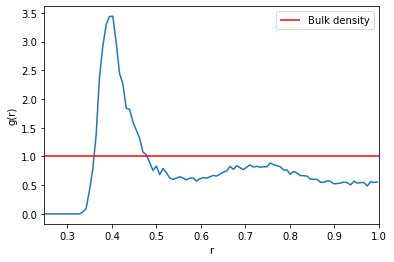

In [74]:
import matplotlib.pyplot as plt

plt.plot(r_vals,gr)
xmin = 0.7*params['sigma']
xmax = params['box_size'][0]/2
plt.xlim([xmin,xmax])
plt.hlines(1.0,xmin,xmax,color="red",label='Bulk density')

plt.xlabel("r")
plt.ylabel("g(r)")
plt.legend()

**Does this curve make sense given the visualization above?  Why or why not?**

/your answer here/

## Running trajectories at different temperatures

Finally, to examine the behavior of this system at different temperatures, run an additional trajectory at each of the following:  $T = 80$, $T = 120$ and $T = 200 K$.

**Save each trajectory to its own numpy array, visualize them using NGLview, and plot their RDF curves.**

In [ ]:
# your code here

In [75]:
all_trajs = {}
all_trajs[50] = traj_pos
for T in [80,120,200]:
    params['kT'] = kB*T*eV_to_dalnap
    all_trajs[T], _ = sim_manager(init_x,init_v,m,LJForces,VVLangevin,params,show_progress=True)

Progress: [####################] 100.0%


**What differences do you observe in the trajectories?**

/ your answer here /

**How are these differences reflected in the $g(r)$ curves?**

/ your answer here /